In [164]:
import numpy
import analysis
import lsst.daf.persistence
import matplotlib
%matplotlib inline
matplotlib.pyplot.rcParams["figure.figsize"] = (16, 9)

In [34]:
reruns = ["old-prior", "new-prior"]

butlers = [lsst.daf.persistence.Butler("/home/jbosch/HSC/data/rerun/HSC-1339/"+rerun) for rerun in reruns]

In [124]:
priors = []
for butler in butlers:
    try:
        config = butler.get("measureCoaddSources_config", immediate=True)
        prior = config.measurement.algorithms["cmodel"].initial.makeControl().getPrior()
    except AttributeError:
        prior = lsst.meas.multifit.SoftenedLinearPrior()
    priors.append(prior)

In [35]:
objs = [analysis.ObjectCatalog.read(butler, tract=8522, patch="5,5", filter="i", forced=False, images=True)
        for butler in butlers]

In [131]:
cosmos = numpy.load("cosmos.npy")

In [36]:
def rTrDiff(cat):
    sdss_xx = cat.i.meas.shape.sdss.xx - cat.i.meas.shape.sdss.psf.xx
    sdss_yy = cat.i.meas.shape.sdss.yy - cat.i.meas.shape.sdss.psf.yy
    sdss_diff = (0.5*(sdss_xx + sdss_yy))**0.5
    hsm_xx = cat.i.meas.shape.hsm.moments.xx - cat.i.meas.shape.hsm.psfMoments.xx
    hsm_yy = cat.i.meas.shape.hsm.moments.yy - cat.i.meas.shape.hsm.psfMoments.yy
    diff = (0.5*(hsm_xx + hsm_yy))**0.5
    sdss_only = numpy.logical_and(numpy.logical_not(numpy.isfinite(diff)), numpy.isfinite(sdss_diff))
    diff[sdss_only] = sdss_diff[sdss_only]
    return diff

In [37]:
def plotPsfVsCModel(cat, title, ymin=-0.1, ymax=1.0, snrCut=5.0):
    snrMask = cat.i.meas.cmodel.flux/cat.i.meas.cmodel.flux.err > snrCut
    matplotlib.pyplot.scatter(cat.i.meas.mag.psf.value,
                              cat.i.meas.mag.psf.value - cat.i.meas.cmodel.mag.value,
                              c='k', s=4, alpha=0.1, linewidth=0, label='no cut')
    print snrMask.sum(), len(cat)
    matplotlib.pyplot.scatter(cat.i.meas.mag.psf.value[snrMask],
                              cat.i.meas.mag.psf.value[snrMask] - cat.i.meas.cmodel.mag.value[snrMask],
                              c=rTrDiff(cat)[snrMask],
                              vmin=-0.1, vmax=2.0,
                              s=12, alpha=0.5, linewidth=0, label='snr > %s'%snrCut)
    matplotlib.pyplot.axhline(0.0, color='k')
    matplotlib.pyplot.colorbar()
    matplotlib.pyplot.ylim(ymin, ymax)
    matplotlib.pyplot.xlim(18.0, 27.0)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.xlabel("psf mag")
    matplotlib.pyplot.ylabel("psf - cmodel")
    matplotlib.pyplot.title(title)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


14400 17494


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt


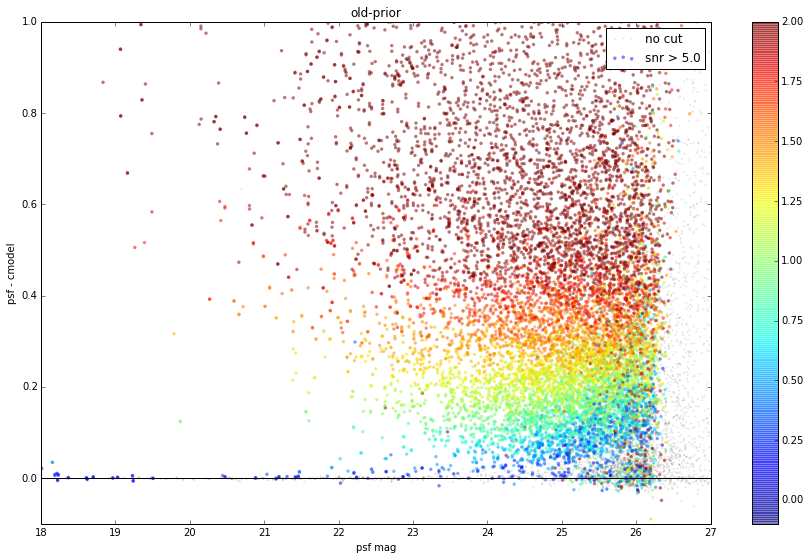

In [38]:
plotPsfVsCModel(objs[0], title=reruns[0], ymax=1)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:4: RuntimeWarning: invalid value encountered in sqrt


14190 17494


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:7: RuntimeWarning: invalid value encountered in sqrt


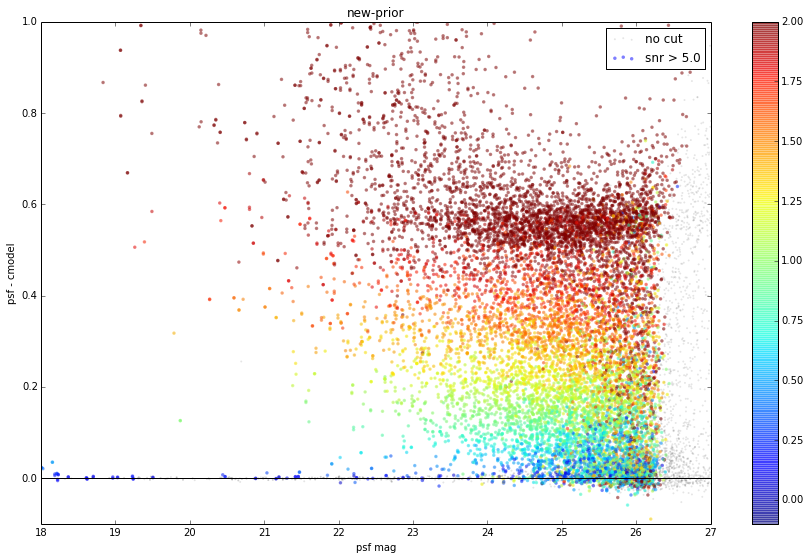

In [39]:
plotPsfVsCModel(objs[1], title=reruns[1], ymax=1)

In [72]:
def plotCModelMagDiff(cat1, cat2, title1, title2, ymin=-1.0, ymax=1.0, snrCut=5.0):
    snrMask = cat2.i.meas.cmodel.flux/cat2.i.meas.cmodel.flux.err > snrCut
    x = cat2.i.meas.mag.psf.value
    y = cat2.i.meas.mag.psf.value - cat2.i.meas.cmodel.mag.value
    z = cat1.i.meas.mag.psf.value - cat1.i.meas.cmodel.mag.value

    matplotlib.pyplot.scatter(x, y, c='k', s=4, alpha=0.1, linewidth=0, label='no cut')
    matplotlib.pyplot.scatter(x[snrMask], y[snrMask], c=z[snrMask], vmin=ymin, vmax=ymax,
                              s=8, alpha=0.5, linewidth=0, label='snr > %s'%snrCut)
    matplotlib.pyplot.axhline(0.0, color='k')
    matplotlib.pyplot.colorbar()
    matplotlib.pyplot.xlim(18.0, 27.0)
    matplotlib.pyplot.ylim(ymin, ymax)
    matplotlib.pyplot.legend()
    matplotlib.pyplot.xlabel("psf mag")
    matplotlib.pyplot.ylabel("psf - cmodel(%s)" % title2)
    matplotlib.pyplot.title("color: psf - cmodel(%s)" % title1)

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:2: RuntimeWarning: invalid value encountered in greater
  from IPython.kernel.zmq import kernelapp as app


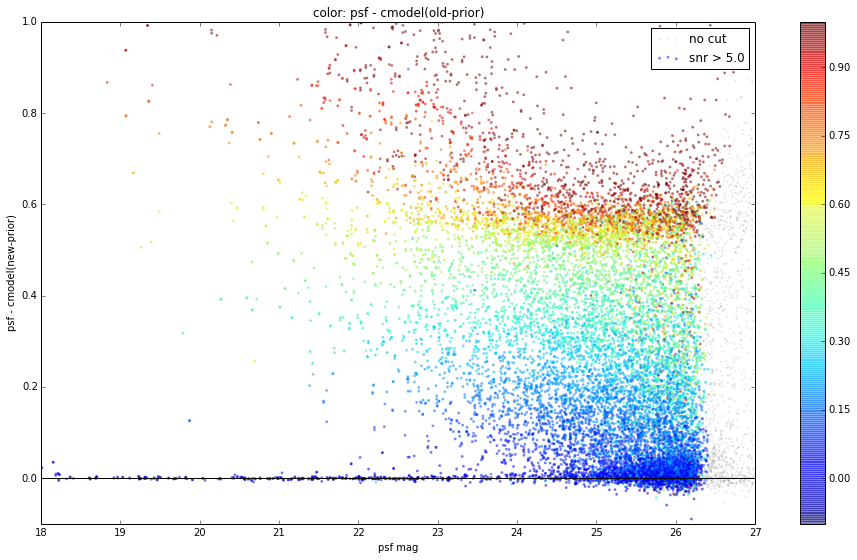

In [170]:
plotCModelMagDiff(objs[0], objs[1], reruns[0], reruns[1], ymin=-0.1, ymax=1.0)
matplotlib.pyplot.savefig("psf-cmodel_prior_comparison.png")

/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:9: RuntimeWarning: invalid value encountered in greater


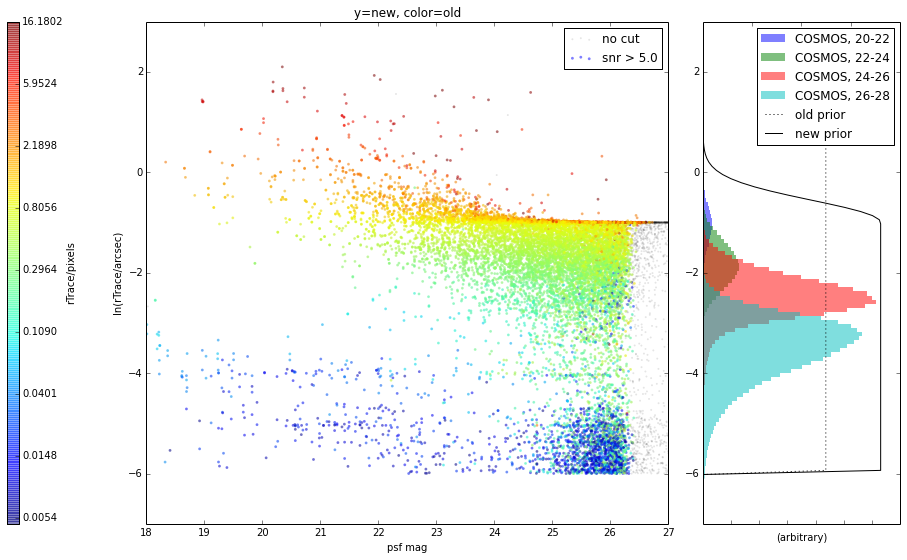

In [171]:
def plotCModelRadiusDiff(cat1, cat2, title1, title2, prior1, prior2, ymin=-6.1, ymax=2.0, snrCut=5.0):
    gs = matplotlib.gridspec.GridSpec(1, 20)
    gs.update(wspace=3)
    cax = matplotlib.pyplot.subplot(gs[0,:1])
    ax1 = matplotlib.pyplot.subplot(gs[0,3:-5])
    ax2 = matplotlib.pyplot.subplot(gs[0,-5:], sharey=ax1)
    
    # Create color scatter plot showing radii vs. PSF for new and old
    snrMask = cat2.i.meas.cmodel.flux/cat2.i.meas.cmodel.flux.err > snrCut
    x = cat2.i.meas.mag.psf.value
    y = numpy.log(cat2.i.meas.cmodel.ellipse.rTr * 0.168)
    z = numpy.log(cat1.i.meas.cmodel.ellipse.rTr * 0.168)
    ax1.scatter(x, y, c='k', s=4, alpha=0.1, linewidth=0, label='no cut')
    mappable = ax1.scatter(x[snrMask], y[snrMask], c=z[snrMask], vmin=ymin, vmax=ymax,
                           s=8, alpha=0.5, linewidth=0, label='snr > %s'%snrCut)
    ax1.legend()
    ax1.set_xlim(18.0, 27.0)
    ax1.set_ylim(ymin, ymax)
    cbar = matplotlib.pyplot.colorbar(mappable, cax=cax, use_gridspec=True)
    cbar.ax.set_yticklabels(["%5.4f" % (numpy.exp(tick)/0.168) for tick in ax1.get_yticks()])
    ax1.set_xlabel("psf mag")
    ax1.set_ylabel("ln(rTrace/arcsec)")
    cax.set_ylabel("rTrace/pixels")
    ax1.set_title("y=%s, color=%s" % (title2, title1))
    
    lines = []
    labels = []
    
    # Add histograms of COSMOS galaxies to the sidebar
    for minMag, maxMag in [(20, 22), (22, 24), (24, 26), (26, 28)]:
        mask = numpy.logical_and(cosmos["mag"] >= minMag, cosmos["mag"] < maxMag)
        lines.append(ax2.hist(cosmos["lnR"][mask], bins=100, range=(ymin, ymax), alpha=0.5,
                              linewidth=0, orientation='horizontal')[2][0])
        labels.append("COSMOS, %d-%d" % (minMag, maxMag))
    
    ax2.set_xticklabels([])
    ax2.set_xlabel("(arbitrary)")
    ax3 = ax2.twiny()
    
    # Add prior values to the sidebar
    def evaluatePrior(prior, s):
        nonlinear = numpy.zeros(3, dtype=float)
        amplitudes = numpy.ones(1, dtype=float)
        result = numpy.zeros(len(s), dtype=float)
        for i in xrange(len(s)):
            nonlinear[2] = s[i]
            result[i] = prior.evaluate(nonlinear, amplitudes)
        result /= result.sum()*(s[1] - s[0])
        return result
    yg = numpy.linspace(ymin, ymax, 100)
    lines.append(ax3.plot(evaluatePrior(prior1, yg), yg, 'k:')[0])
    labels.append(title1 + " prior")
    lines.append(ax3.plot(evaluatePrior(prior2, yg), yg, 'k-')[0])
    labels.append(title2 + " prior")
    
    ax3.set_xticklabels([])
    ax3.legend(lines, labels)
    
plotCModelRadiusDiff(objs[0], objs[1], "old", "new", priors[0], priors[1])
matplotlib.pyplot.savefig("rTrace_prior_comparison.png")

In [ ]:
def display(catalog, snrCut=5.0, magLimit=25.0, magDiff=1.0, images=False, frame0=0, fitRegions=False):
    snrMask = numpy.logical_and.reduce([
        catalog.i.meas.cmodel.flux/catalog.i.meas.cmodel.flux.err > snrCut,
        catalog.detect.is_primary == True,
        numpy.logical_not(catalog.i.meas.cmodel.flux.flags),
    ])
    badMask = numpy.logical_and.reduce([
        snrMask,
        catalog.i.meas.mag.psf > magLimit,
        catalog.i.meas.mag.psf - catalog.i.meas.cmodel.mag > magDiff
    ])
    display = catalog.display(frame0=frame0)
    if images:
        display.images()
    display.cmodel(catalog[badMask], fitRegions=fitRegions)
    display.kron(catalog[badMask], clear=False, radiusForRadius=False)
    #display.footprints(catalog[badMask], clear=False)
    print badMask.sum()

In [170]:
display(objs[0], frame0=0)

550


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


In [163]:
display(objs[2], frame0=1, fitRegions=True)

456


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


In [164]:
display(objs[3], frame0=2, images=True, fitRegions=True)

Assigning red to mask plane NOT_DEBLENDED
446


/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:3: RuntimeWarning: invalid value encountered in greater
  app.launch_new_instance()
/usr/local/lib/python2.7/dist-packages/IPython/kernel/__main__.py:10: RuntimeWarning: invalid value encountered in greater


In [115]:
(objs[1].i.meas.cmodel.flux == objs[2].i.meas.cmodel.flux).sum()

16832

In [6]:
def plotTiming(cat, rerun, sym='-'):
    mask = numpy.logical_not(cat.i.meas.cmodel.flux.flags)
    base = cat.i.meas.cmodel[mask]
    total = base.exp.time + base.dev.time + base.initial.time
    idx = numpy.argsort(total)
    matplotlib.pyplot.plot(numpy.cumsum(total[idx]), "k"+sym, alpha=0.8, label="total "+rerun)
    matplotlib.pyplot.plot(numpy.cumsum(base.initial.time.value[idx]), "g"+sym, label="initial "+rerun)
    matplotlib.pyplot.plot(numpy.cumsum(base.exp.time.value[idx]), "b"+sym, label='exp '+rerun)
    matplotlib.pyplot.plot(numpy.cumsum(base.dev.time.value[idx]), "r"+sym, label='dev '+rerun)
    matplotlib.pyplot.legend(loc="upper left")
    matplotlib.pyplot.xlabel("object index")
    matplotlib.pyplot.ylabel("cumulative time (s)")

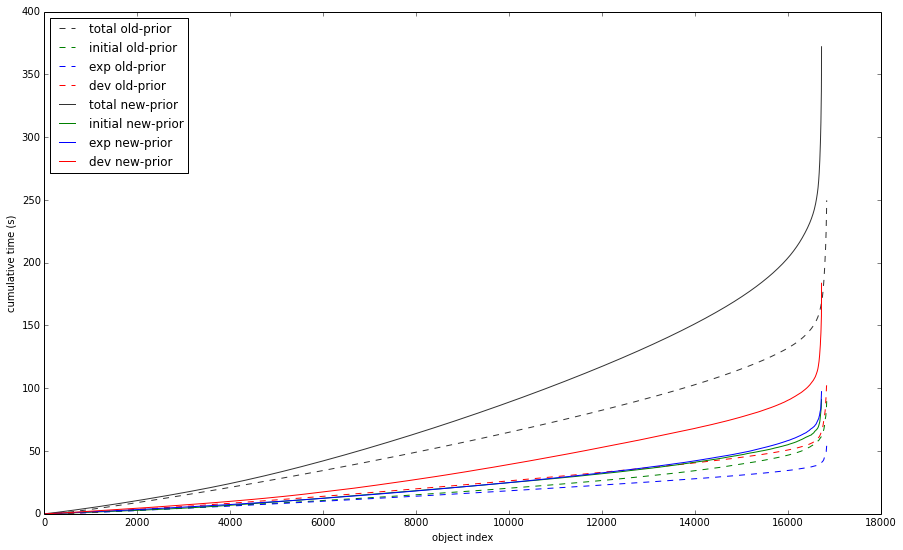

In [9]:
plotTiming(objs[0], reruns[0], '--')
plotTiming(objs[1], reruns[1], '-')